In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



labels_df = pd.read_csv("training-english/labels_training.tsv", sep="\t")
sentences_df = pd.read_csv("training-english/sentences_training.tsv", sep="\t")

df = pd.merge(labels_df, sentences_df, on=["Text-ID", "Sentence-ID"])
print(df.shape, df.columns[:10])  

(44758, 41) Index(['Text-ID', 'Sentence-ID', 'Self-direction: thought attained',
       'Self-direction: thought constrained',
       'Self-direction: action attained', 'Self-direction: action constrained',
       'Stimulation attained', 'Stimulation constrained', 'Hedonism attained',
       'Hedonism constrained'],
      dtype='object')


## Frequency of each label

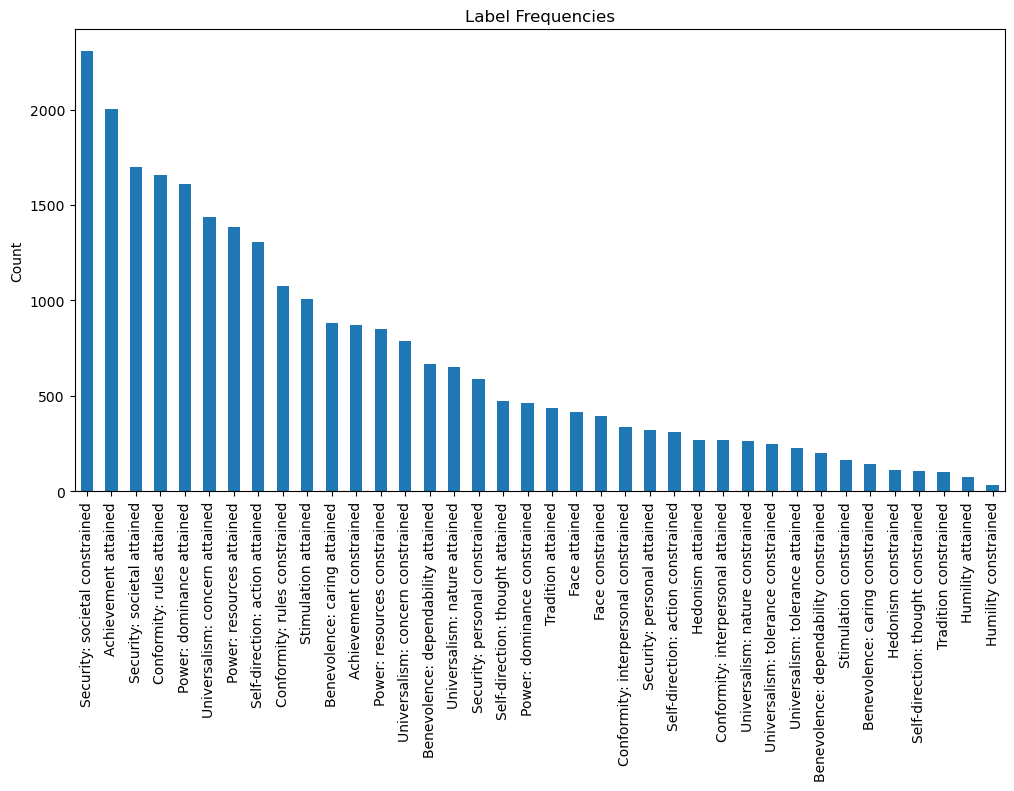

In [72]:
label_cols = df.columns[2:-1]  
label_counts = df[label_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
label_counts.plot(kind="bar")
plt.title("Label Frequencies")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

## Top/rare labels

In [75]:
print("Top 5 most frequent labels:")
print(label_counts.head())

print("\nBottom 5 rarest labels:")
print(label_counts.tail())


Top 5 most frequent labels:
Security: societal constrained    2304.5
Achievement attained              2001.5
Security: societal attained       1699.5
Conformity: rules attained        1655.0
Power: dominance attained         1610.5
dtype: float64

Bottom 5 rarest labels:
Hedonism constrained                   114.5
Self-direction: thought constrained    106.0
Tradition constrained                  104.0
Humility attained                       76.0
Humility constrained                    32.0
dtype: float64


## Co-occurrence heatmap

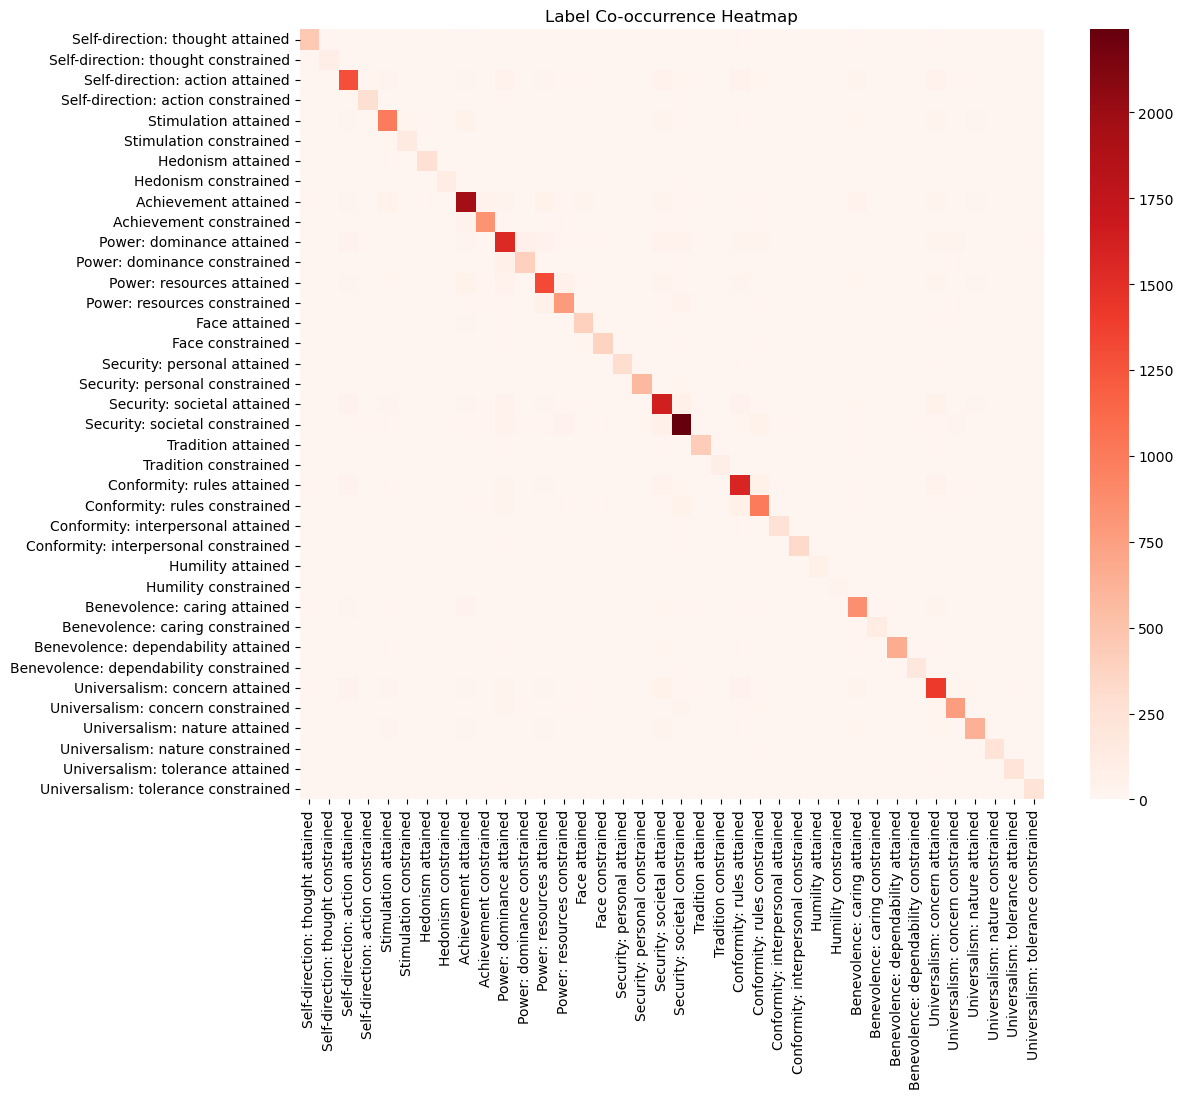

In [78]:

co_matrix = df[label_cols].T.dot(df[label_cols])  # co-occurrence counts
plt.figure(figsize=(12,10))
sns.heatmap(co_matrix, cmap="Reds")
plt.title("Label Co-occurrence Heatmap")
plt.show()


## Sentence length distribution

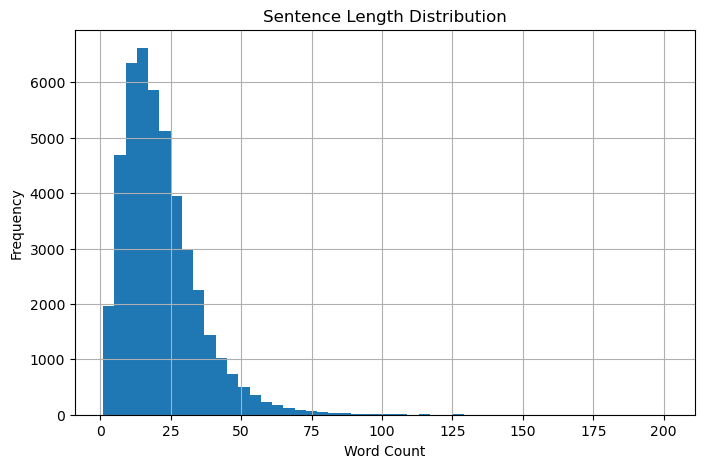

In [80]:
df["sentence_length"] = df["Text"].str.split().str.len()

plt.figure(figsize=(8,5))
df["sentence_length"].hist(bins=50)
plt.title("Sentence Length Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

## Average sentence length per label

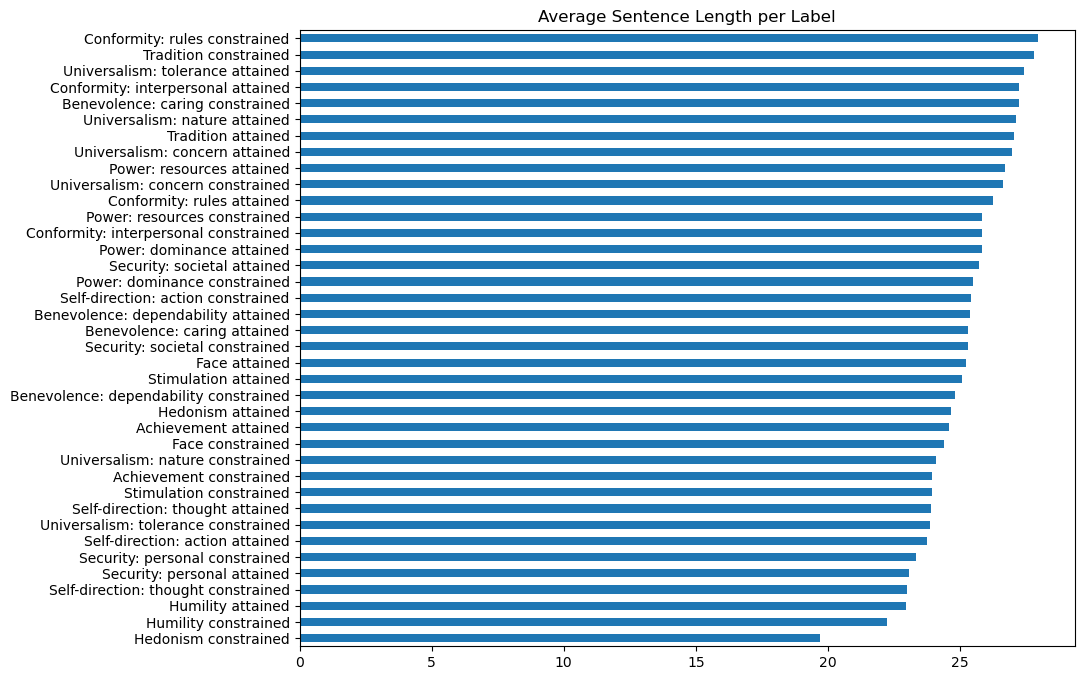

In [84]:
avg_len_per_label = {}
for col in label_cols:
    avg_len_per_label[col] = df.loc[df[col]==1, "sentence_length"].mean()

avg_len_series = pd.Series(avg_len_per_label).sort_values()
avg_len_series.plot(kind="barh", figsize=(10,8))
plt.title("Average Sentence Length per Label")
plt.show()

## Text-ID Coverage

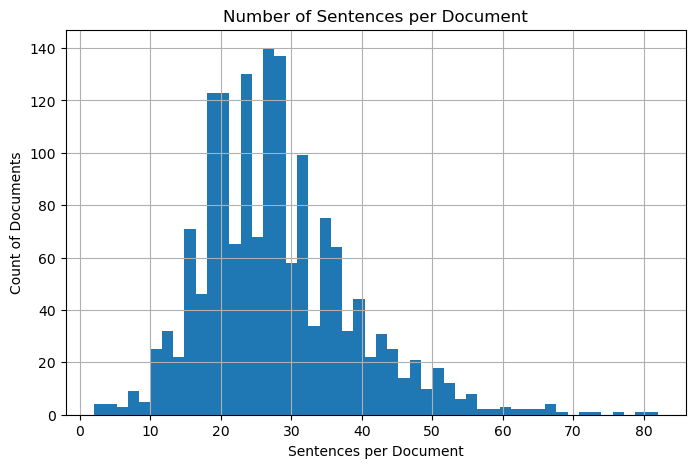

In [87]:
doc_sent_counts = df.groupby("Text-ID")["Sentence-ID"].count()
doc_sent_counts.hist(bins=50, figsize=(8,5))
plt.title("Number of Sentences per Document")
plt.xlabel("Sentences per Document")
plt.ylabel("Count of Documents")
plt.show()

## Attained vs constrained ratio

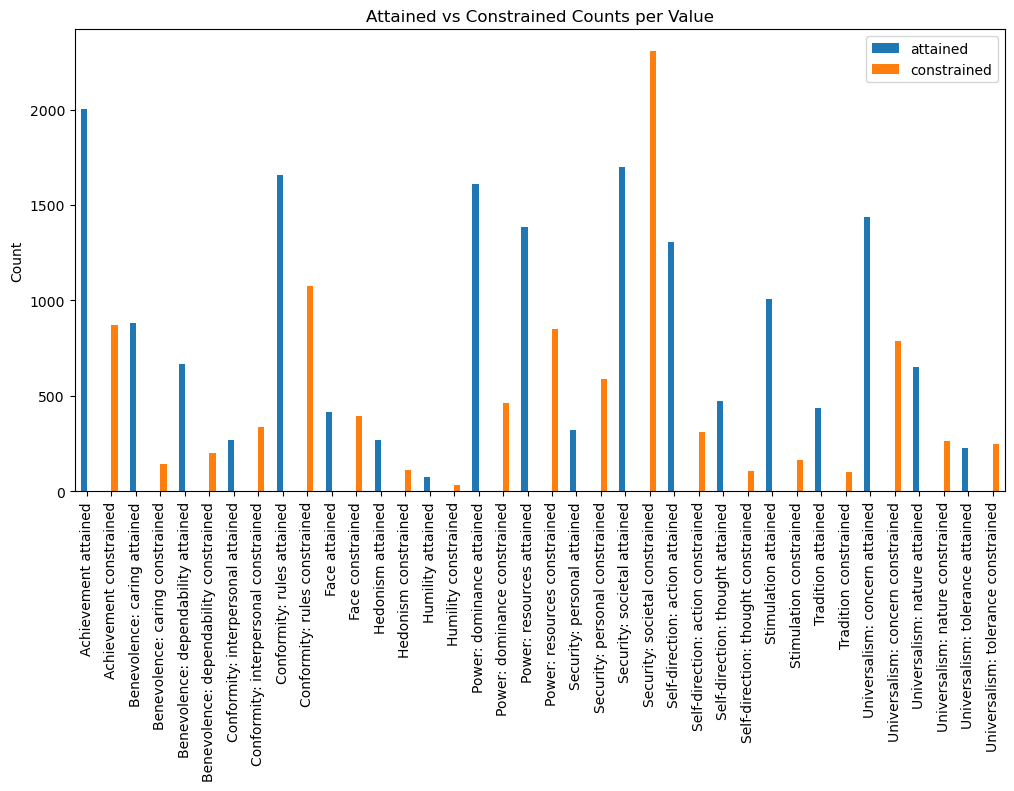

In [90]:
attained = [c for c in label_cols if "attained" in c]
constrained = [c for c in label_cols if "constrained" in c]

attained_counts = df[attained].sum()
constrained_counts = df[constrained].sum()

ratio_df = pd.DataFrame({"attained": attained_counts, "constrained": constrained_counts})
ratio_df.plot(kind="bar", figsize=(12,6))
plt.title("Attained vs Constrained Counts per Value")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

## Positive vs negative skew

Sentences with no labels: 21696
Sentences with at least 1 label: 23062


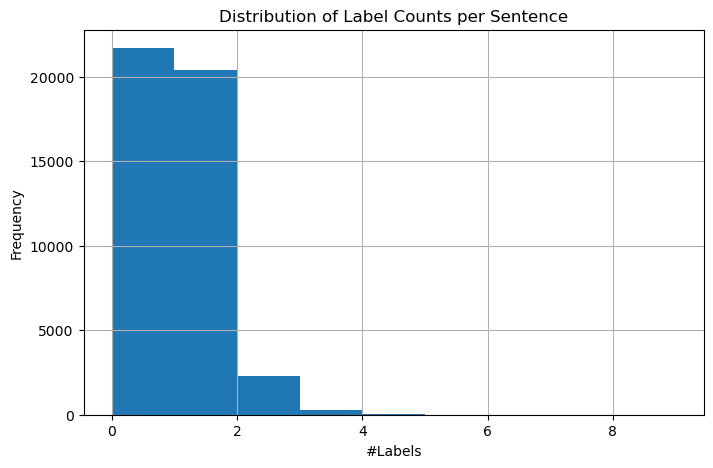

In [93]:
df["num_labels"] = df[label_cols].sum(axis=1)
df["has_label"] = df["num_labels"] > 0

print("Sentences with no labels:", (~df["has_label"]).sum())
print("Sentences with at least 1 label:", df["has_label"].sum())

df["num_labels"].hist(bins=range(0,10), figsize=(8,5))
plt.title("Distribution of Label Counts per Sentence")
plt.xlabel("#Labels")
plt.ylabel("Frequency")
plt.show()

## Correlation matrix between labels

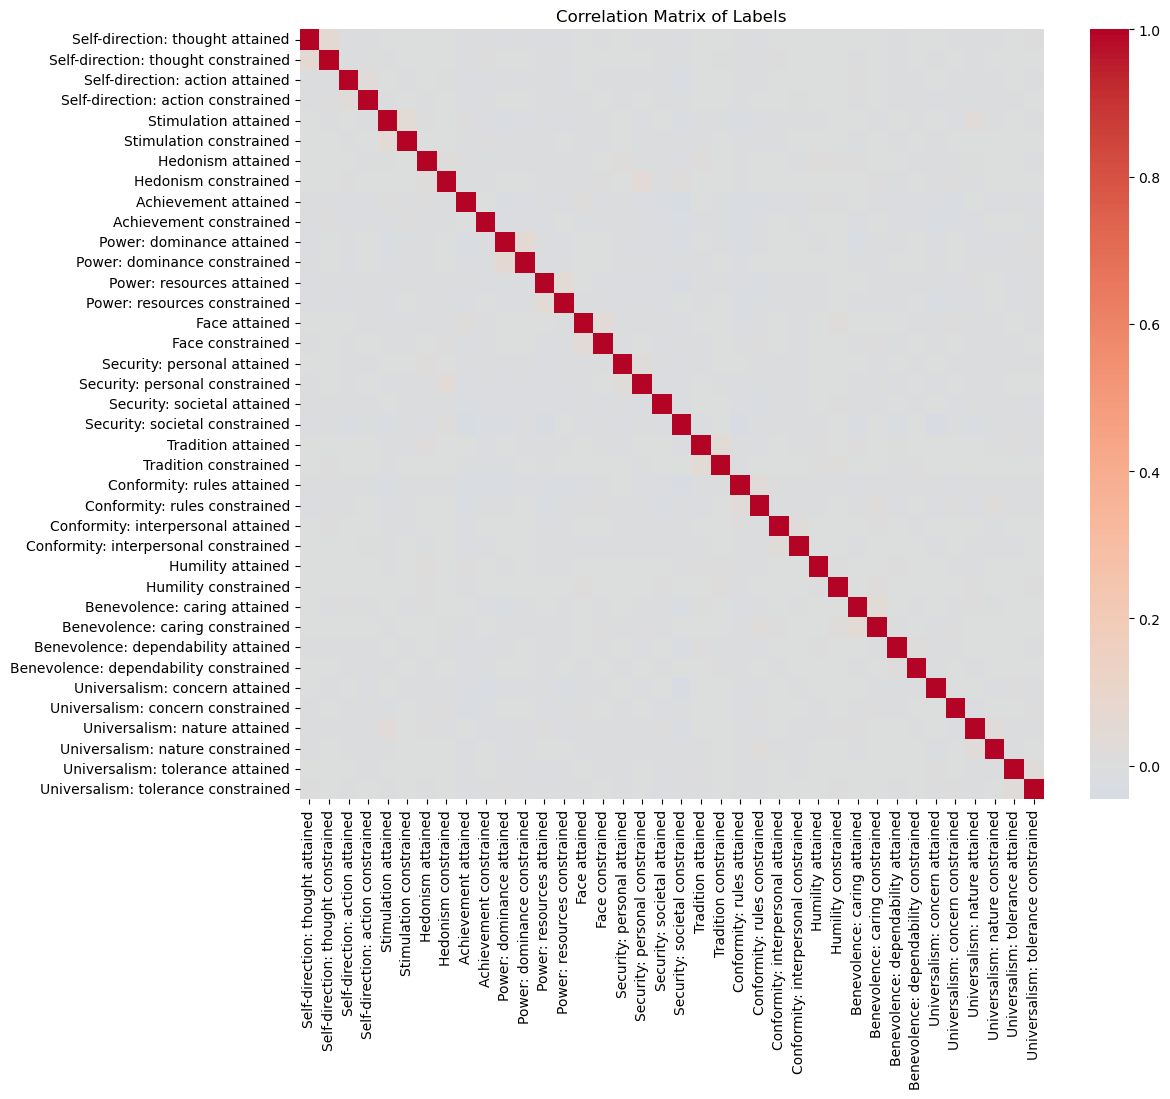

In [96]:
corr_matrix = df[label_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Labels")
plt.show()

## Multilabel density

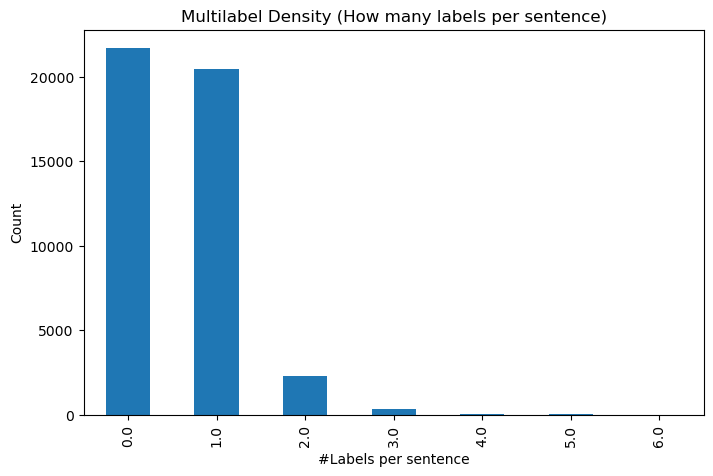

In [99]:
label_density = df["num_labels"].value_counts().sort_index()
label_density.plot(kind="bar", figsize=(8,5))
plt.title("Multilabel Density (How many labels per sentence)")
plt.xlabel("#Labels per sentence")
plt.ylabel("Count")
plt.show()

## Word clouds / top keywords

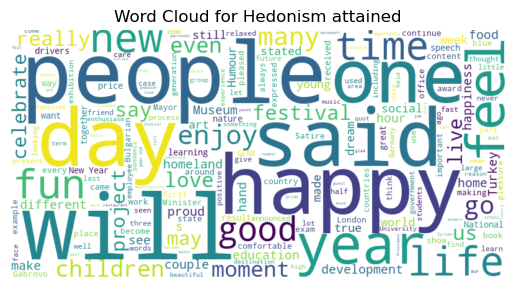

In [104]:
from wordcloud import WordCloud

# Example: for "Hedonism attained"
text_for_label = " ".join(df.loc[df["Hedonism attained"]==1, "Text"].tolist())
wc = WordCloud(width=800, height=400, background_color="white").generate(text_for_label)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Hedonism attained")
plt.show()

## TF-IDF analysis

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X = vectorizer.fit_transform(df["Text"])

# Example: get top words for "Achievement attained"
y = df["Achievement attained"]
class0_mean = X[y==0].mean(axis=0)
class1_mean = X[y==1].mean(axis=0)

diff = (class1_mean - class0_mean).A1
top_idx = diff.argsort()[-20:][::-1]
top_words = [vectorizer.get_feature_names_out()[i] for i in top_idx]

print("Top distinguishing words for Achievement attained:")
print(top_words)

Top distinguishing words for Achievement attained:
['percent', 'year', 'world', 'best', 'success', 'successful', 'billion', 'largest', 'high', 'won', 'million', 'win', 'education', 'award', 'economy', 'achieved', 'skills', 'number', 'victory', 'results']
